In [1]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)

___

In [2]:
# Load the data
d = pd.read_csv('titanic.csv')
survived = d['Survived']

In [3]:
d.drop("PassengerId", axis=1).describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Checklist:
    - create new variables (enhansment of some variables: child, or women on the first class)
    - drop irrelevant variables ('Name', 'Ticket', 'Cabin')
    - fill nulls (mean, median, 0, depending on the data)
    - deal with categorical - possibly create dummy variables ('Sex', 'Embarked')
    - normilize/standadize variables
    - balance the data set (by the dependant variable)
    - check for correlation (possibly drop variables)

In [4]:
d = d.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

In [5]:
print(d.isnull().sum(axis = 0))

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [6]:
# Dealing with null values, for numerical:
for col in d.columns:
    if d[col].dtype != object:
        d[col]=d[col].fillna(d[col].mean())
#could think of a better way such as use the different mens for male and female

In [7]:
print(d.isnull().sum(axis = 0))

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64


In [8]:
d.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [9]:
# Create dummies - for better model outcomes
d = pd.get_dummies(d)
d.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [10]:
# Data Normalization
names = d.columns
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(d[["Age", "Fare"]])
d[["Age", "Fare"]] = scaled_d
d.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.271174,1,0,0.014151,0,1,0,0,1
1,1,0.472229,1,0,0.139136,1,0,1,0,0
2,3,0.321438,0,0,0.015469,1,0,0,0,1
3,1,0.434531,1,0,0.103644,1,0,0,0,1
4,3,0.434531,0,0,0.015713,0,1,0,0,1


In [11]:
d['Survived'] = pd.Series(survived)

# Class balance
ld = d[d.Survived == 1]
no_ld = d[d.Survived == 0]
print("SURVIVED: ", len(ld), " NOT SURVIVED: ", len(no_ld))

SURVIVED:  342  NOT SURVIVED:  549


In [12]:
balanced_d = pd.concat([ld, no_ld.sample(len(ld))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(684, 11)

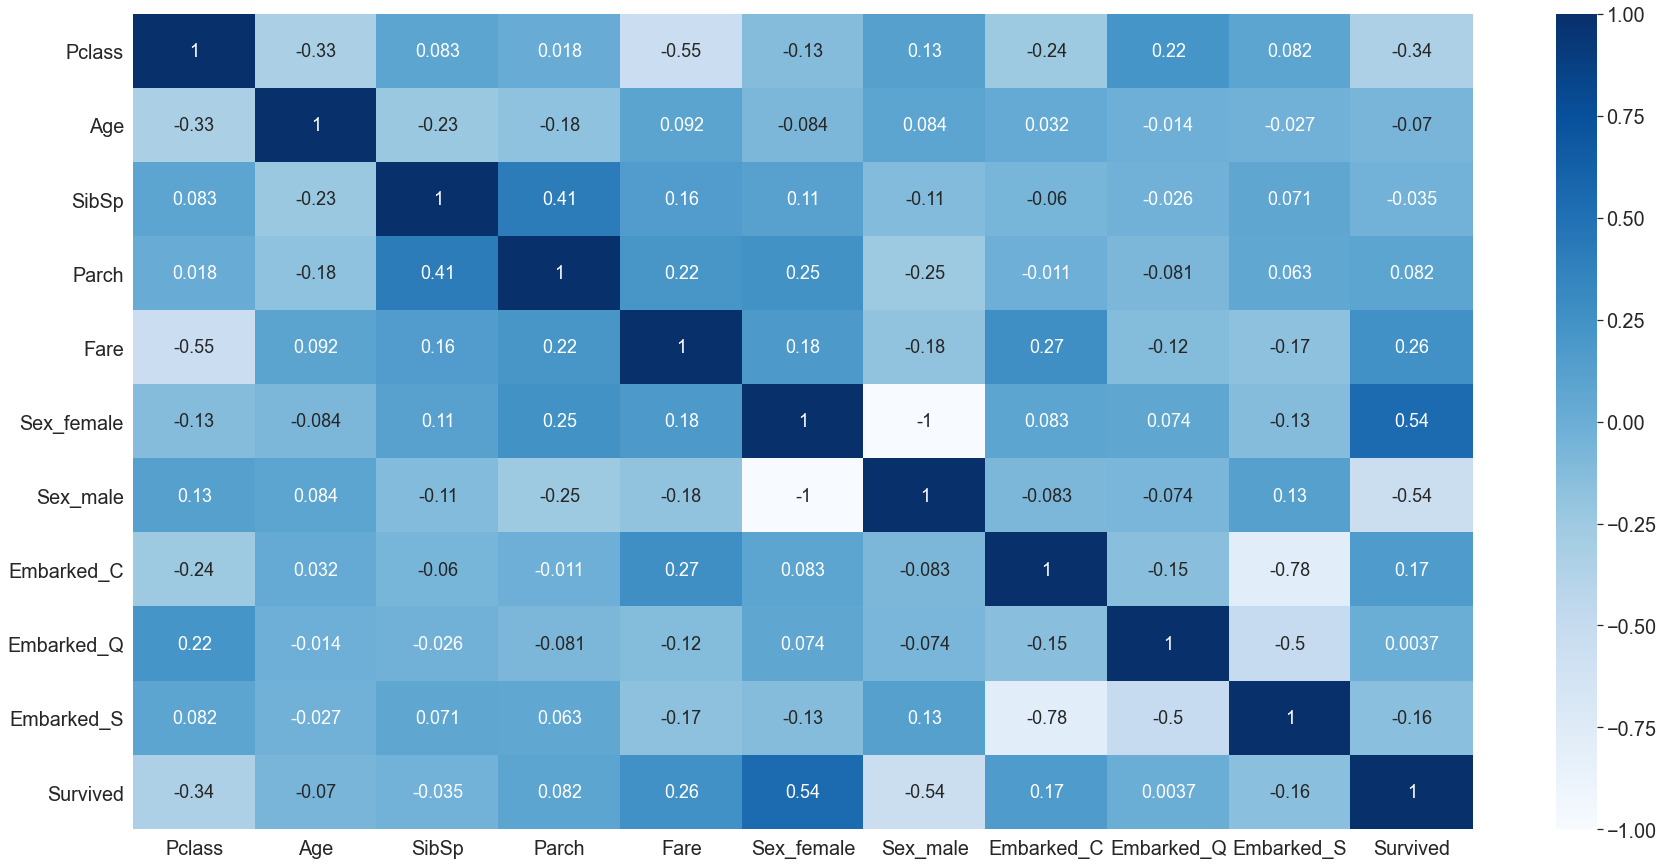

In [13]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(d[d.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [14]:
# Drop values to avoid variables with too high correlation
x = x.drop(['Sex_male', 'Embarked_C'], axis=1)

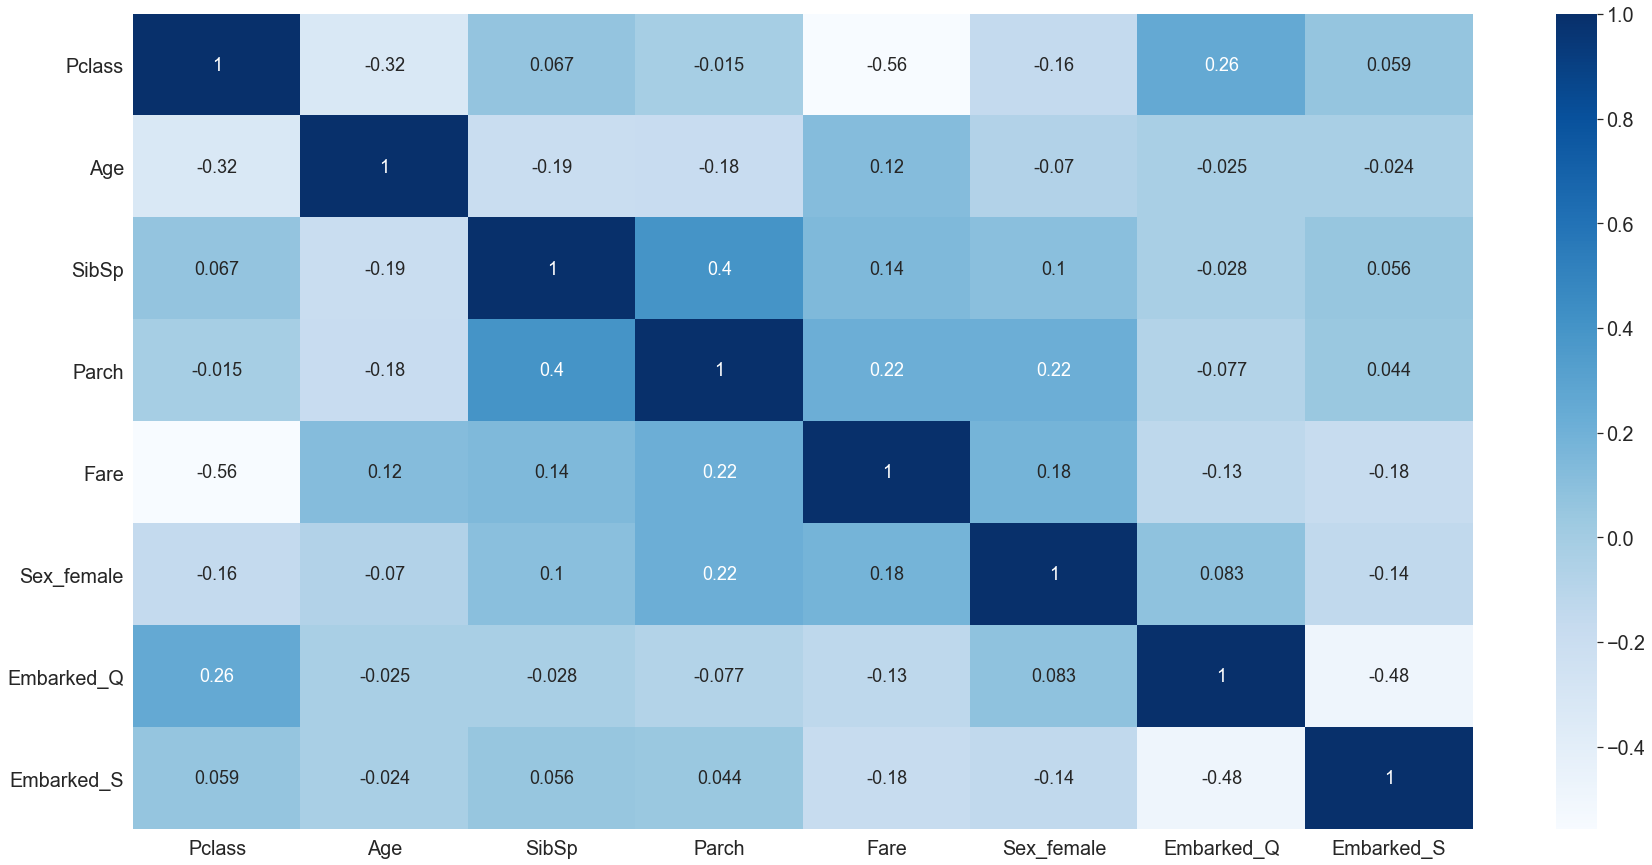

In [15]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(x.corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

____
## CLASSIFICATION

In [16]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(547, 8)
(137, 8)
(547, 1)
(137, 1)


In [17]:
y_train[:3]

,Survived
276,0
653,1
532,0


In [20]:
# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True),
    LinearDiscriminantAnalysis(),
    AdaBoostClassifier((DecisionTreeClassifier(random_state=rs)), random_state=rs, learning_rate=0.1),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    GradientBoostingClassifier(random_state=rs),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=10) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [21]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Accuracy: 0.74 	 ---> LogisticRegression 
Accuracy: 0.71 	 ---> DecisionTreeClassifier 
Accuracy: 0.72 	 ---> SVC 
Accuracy: 0.76 	 ---> LinearDiscriminantAnalysis 
Accuracy: 0.76 	 ---> AdaBoostClassifier 
Accuracy: 0.75 	 ---> RandomForestClassifier 
Accuracy: 0.78 	 ---> GradientBoostingClassifier 


Text(0.5, 1.0, 'Cross validation scores')

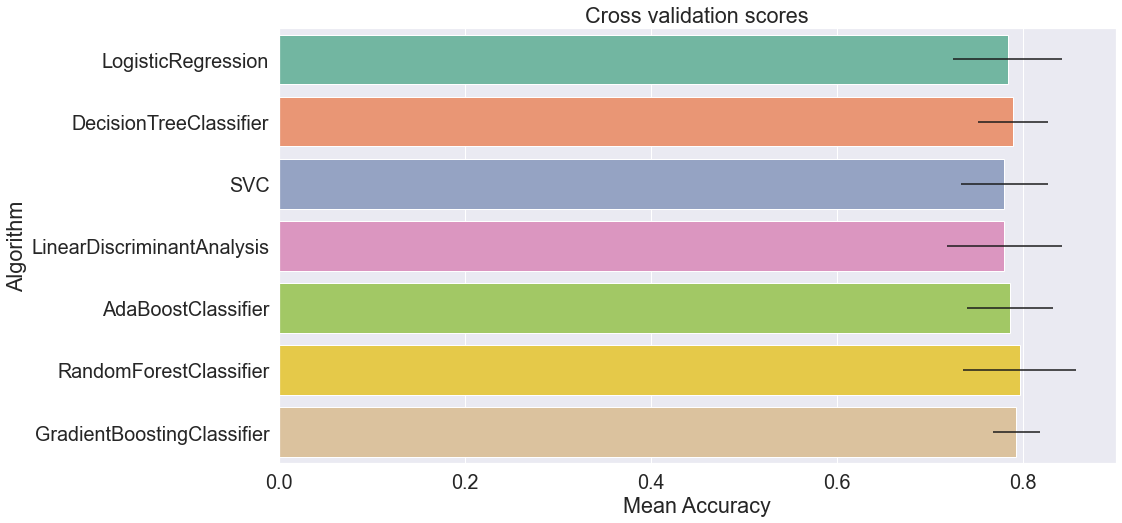

In [22]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(15,8))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

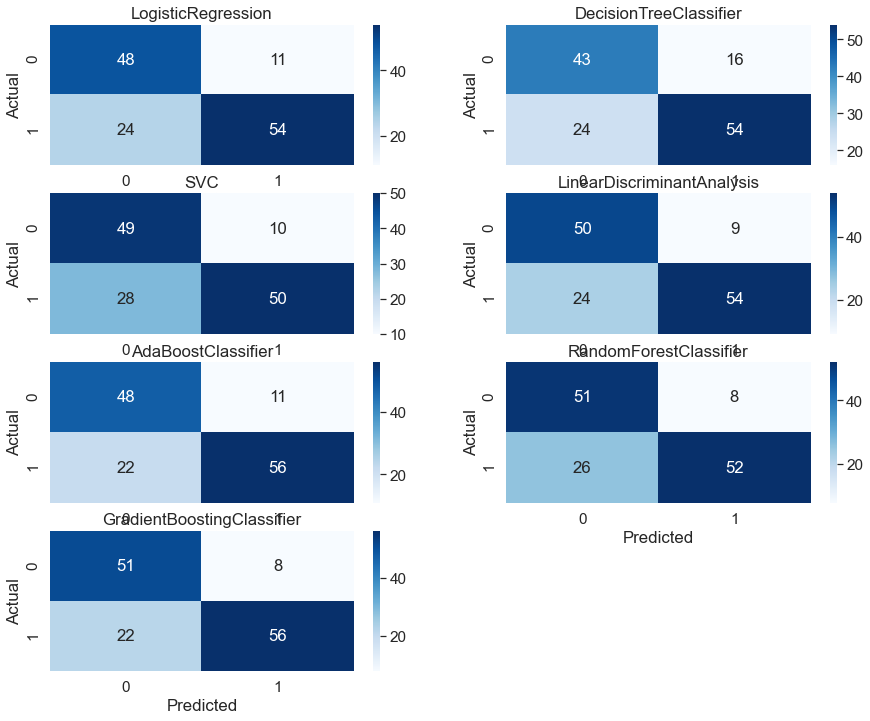

In [23]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(15,15))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(5,2,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [24]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73        59
           1       0.83      0.69      0.76        78

    accuracy                           0.74       137
   macro avg       0.75      0.75      0.74       137
weighted avg       0.76      0.74      0.75       137

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        59
           1       0.77      0.69      0.73        78

    accuracy                           0.71       137
   macro avg       0.71      0.71      0.71       137
weighted avg       0.72      0.71      0.71       137

SVC Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72        59
           1       0.83      0.64      0.72        78

    accuracy                           0.72       137
   macro avg 

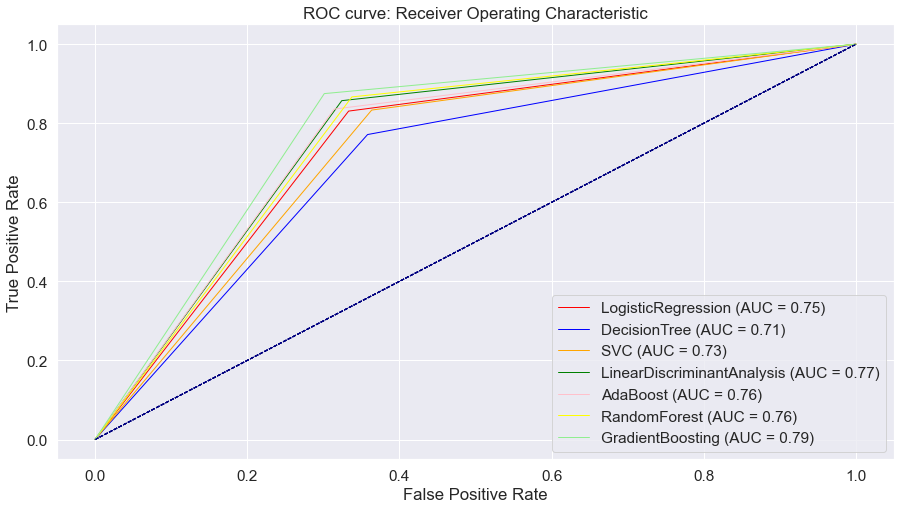

In [25]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
# Search grid for optimal parameters

DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

GB_param = {'loss' : ["deviance"],
            'n_estimators' : [100,200,300],
            'learning_rate': [0.1, 0.05, 0.01],
            'max_depth': [4, 8],
            'min_samples_leaf': [100,150],
            'max_features': [0.3, 0.1]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
GBgs = GridSearchCV(GradientBoostingClassifier(), param_grid=GB_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs, GBgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   31.1s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   42.0s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   42.4s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    3.1s


In [ ]:
# scores without gridsearch
print("score without GridSearchCV: ", cv_acc[:2])
# scores with gridsearch
print("score with GridSearchCV: ", score)

In [ ]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop("Survived", axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [ ]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1]), ('gb',gs_model[2])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

### VOTING TYPE:
- HARD: uses predicted class labels for majority rule voting
- SOFT: predicts the class label based on the argmax of the sums of the predicted probabilities

In [ ]:
# Load the test data
d2 = pd.read_csv('titanic_test.csv')
PassengerId = d2['PassengerId'] #save this variable for correct format of the submision

# Drop values
d2 = d2.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Dealing with null values, for numerical:
for col in d2.columns:
    if d2[col].dtype != object:
        d2[col]=d2[col].fillna(d[col].mean())

# Create dummies - for better model outcomes (also deals with nulls in categorical)
d2 = pd.get_dummies(d2)

# Data Normalization

scaled_d2 = scaler.transform(d2[["Age", "Fare"]])
d2[["Age", "Fare"]] = scaled_d2

# Drop values to avoid multicolinearity
d2 = d2.drop(['Sex_male', 'Embarked_C'], axis=1)

In [ ]:
#train the model on the whole dataset and produce results:
survived_pred = pd.Series(best_model.predict(d2), name='Survived')

In [ ]:
survived_pred.value_counts()

## YELLOWBRICK

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

In [ ]:
# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["not_survived", "survived"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [ ]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

In [ ]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure